# Проект "Прогнозирование заказов такси"

# Table of Contents
* [Описание проекта](#0.Описание)
    * [Цель проекта](#0.1.Цель)
    * [План работ](#0.2.План)
    * [Примечания к плану работ](#0.3.Прим)
    * [Данные](#0.3.Данные)
* [1. Подготовка данных](#1.Глава1)
    * [1.1. Импорт библиотек](#1.1.Импорт_библиотек)
    * [1.2. Определение констант](#1.2.Опред_констант)
    * [1.3. Загрузка данных](#1.3.Загрузка_данных)
    * [1.4. Тренды и сезоны](#1.4.Допочистка)
    * [1.5. Проверка на стационарность](#1.5.Стационарность)    
    * [1.6. Подготовка признаков](#1.6.Подг_признаков)
* [2. Подготовка наборов](#2.Подг_наборов)
    * [2.1. Разделение наборов на таргеты и признаки](#2.1.Таргет_Призн)
    * [2.2. Масштабирование](#2.2.OHE)
    * [2.3. Разделение train, test ](#2.3.Train_test)
* [3. Обучение моделей](#3.Обучение_мод)
    * [3.1. Линейная регрессия](#3.1.LR)
    * [3.2. CatBoost](#3.2.CBR)
    * [3.3. LightGBM](#3.3.LGBM)
* [4. Вывод](#4.Вывод)

# Описание проекта <a class="anchor" id="0.Описание"></a>

## Цель проекта <a class="anchor" id="0.1.Цель"></a>

1. Описание проекта
2. Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
3. Значение метрики RMSE на тестовой выборке должно быть не больше 48.


## План работ <a class="anchor" id="0.2.План"></a>

1. Инструкция по выполнению проекта
2. Загрузите данные и выполните их ресемплирование по одному часу.
3. Проанализируйте данные.
4. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
5. Проверьте данные на тестовой выборке и сделайте выводы.

# 1. Загрузка и подготовка данных <a class="anchor" id="1.Глава1"></a>


## 1.1 Импорт библиотек <a class="anchor" id="1.1.Импорт_библиотек"></a>

In [96]:
import os

import time
from datetime import timedelta

import pandas as pd
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)
#pd.set_option('display.width', 1000)
import numpy as np
from numpy.linalg import inv, cond

import random
from random import randrange

from sklearn.datasets import make_spd_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance 
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

from scipy import stats as st
from seaborn import pairplot, heatmap,stripplot

from random import randrange

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


## 1.2 Определение констант <a class="anchor" id="1.2.Опред_констант"></a>

In [97]:

RANDOM_STATE = 27182
state = np.random.RandomState(RANDOM_STATE)


## 1.3 Загрузка и проверка данных <a class="anchor" id="1.3.Загрузка_данных"></a>

1. Загружаем данные.
2. Проверяем на NaN, мультиколинерность, дублирование категориальных признаков, лишние данные/столбцы.
3. Убираем дублирование.

In [98]:

try:
    df = pd.read_csv(r'c:\%Users%\datasets\taxi.csv',index_col=[0], parse_dates=[0])   
    print('Загрузился Path Windows!')
except Exception:
    print('Это не Windows!')
    
try:
    df = pd.read_csv(r'/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    print('Загрузился Path Yandex!')

except Exception:
    print('Это не Yandex!')    


Загрузился Path Windows!
Это не Yandex!


In [99]:

def about_tsa(df,sample_size=5, graph = False):
    print(f'Первые {sample_size} строк')
    display(df.head(sample_size))
    print(f'Последние {sample_size} строк')
    display(df.tail(sample_size))
    print(f'\n Основная информация')
    print(df.info())
    display(df.describe(include='all'))
    df = df.sort_index()
    print('df.index.is_monotonic - ',df.index.is_monotonic)
       
    print(f'\n Кол-во и доля пропусков')
    
    display(
        pd.DataFrame(
            np.array([df.isna().sum(), df.isna().mean()]).T,
            columns = ['кол-во пропусков','доля пропусков'],
            index=df.columns
        ).style.background_gradient('coolwarm')
    )
    
    print(f'\n Кол-во и доля дубликатов')
    
    display( df.duplicated().head() )
    print(1 - df.duplicated().value_counts()/len(df) )

1. Проверяем df
2. Функция проверки NaN, мультиколинерность, дублирование категориальных признаков, лишние данные/столбцы.

In [100]:

about_tsa(df)


Первые 5 строк


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Последние 5 строк


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53



 Основная информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


df.index.is_monotonic -  True

 Кол-во и доля пропусков


,кол-во пропусков,доля пропусков
num_orders,0.000000,0.000000



 Кол-во и доля дубликатов


datetime
2018-03-01 00:00:00    False
2018-03-01 00:10:00    False
2018-03-01 00:20:00    False
2018-03-01 00:30:00    False
2018-03-01 00:40:00    False
dtype: bool

True     0.003057
False    0.996943
dtype: float64


Функция проверки:
1. пропуски и NaN
2. мультиколинерность
3. графики
4. лишние данные/столбцы

In [101]:

df.sort_index(inplace=True)
df = df.resample('1H').sum()
print(df.describe())
print(df.info())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


In [102]:
df.shape

(4416, 1)

## 1.4. Тренды и сезоны <a class="anchor" id="1.4.Допочистка"></a>

1. Попробуем разделить сезонную и трендовые составляющие:
2. Для часовиков сезон очевидно это день, день недели уже не заметен
3. Если свернуть кол-во вызовов в дни, сезоном становяться дни недели
4. Т.е. имеет место минимум два сезонных цикла - суточные и недельные:
5. Для суток - минимум 6:00, макссимум 24:00
6. Для дней недели - пики понедельник, пятница, минимумы вторник, воскресенье
5. На эти два цикла накладываются праздники или происшествия транспорта
6. Скользящее среднее 168 часов и особенно 720часов показывает тренд, но очень сильно отстает от значений

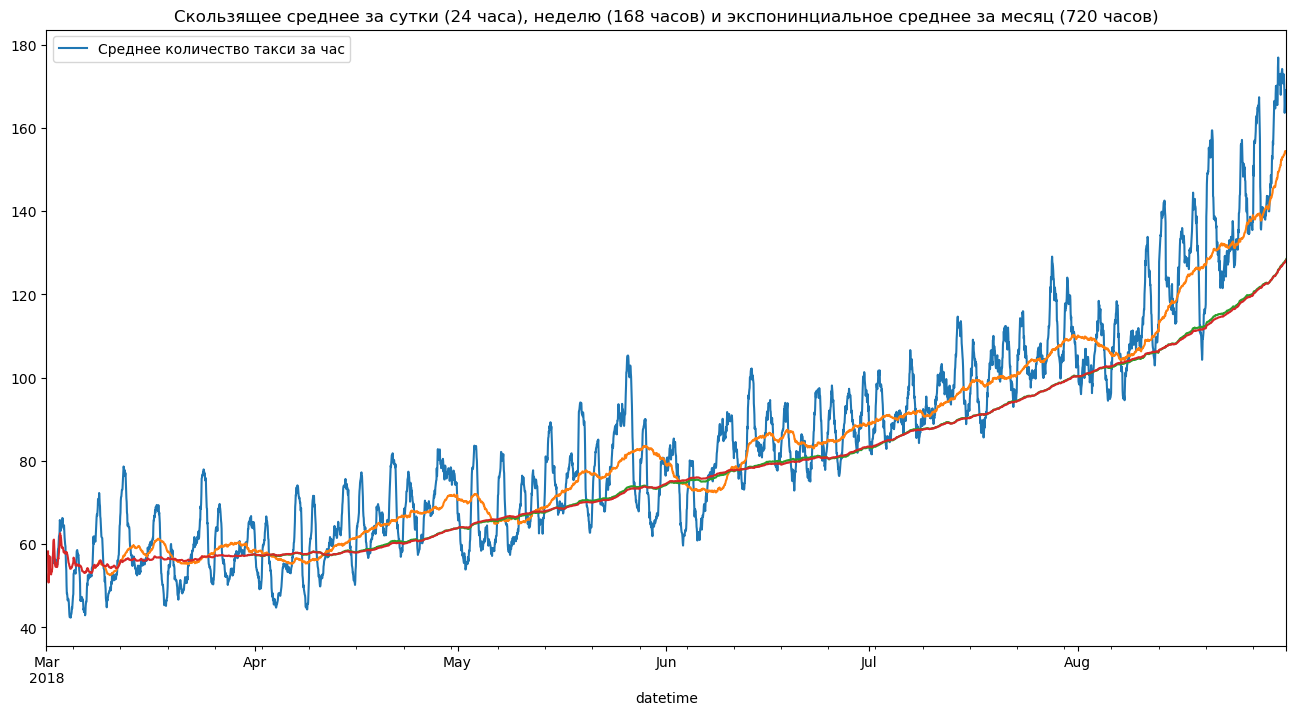

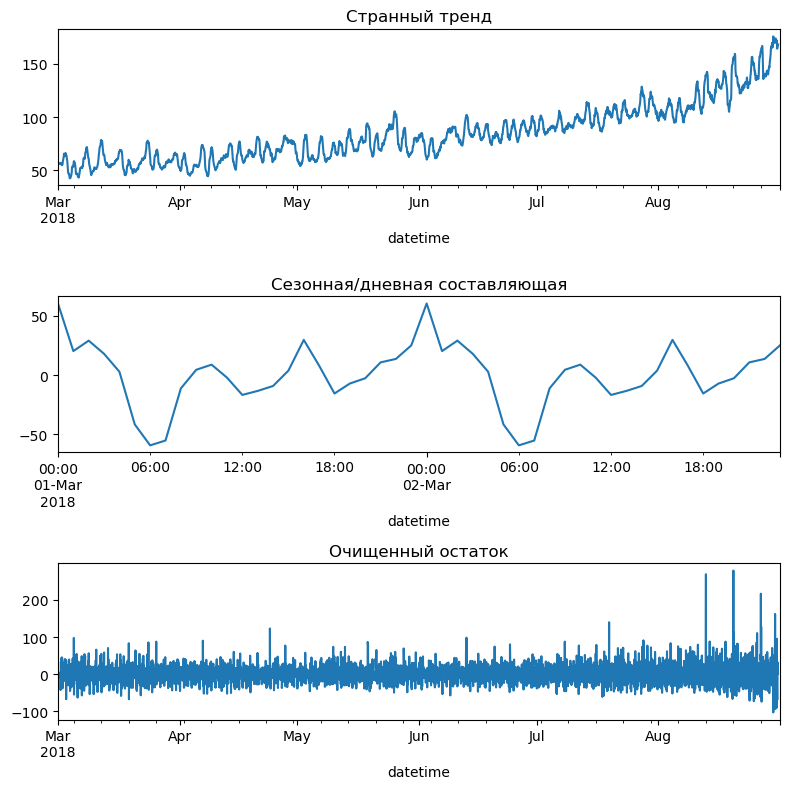

In [103]:
df['num_orders'].rolling(24).mean().plot(figsize=(16, 8))
df['num_orders'].rolling(168).mean().plot(figsize=(16, 8))
df['num_orders'].rolling(720).mean().plot(figsize=(16, 8))
df['num_orders'].rolling(window=720, min_periods=7, win_type='exponential').mean(tau=720).plot(figsize=(16, 8))
plt.legend(['Среднее количество такси за час'])
plt.title('Скользящее среднее за сутки (24 часа), неделю (168 часов) и экспонинциальное среднее за месяц (720 часов)')

decomposed = seasonal_decompose(df)
 
plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Странный тренд')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Сезонная/дневная составляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Очищенный остаток')
plt.tight_layout()


/n


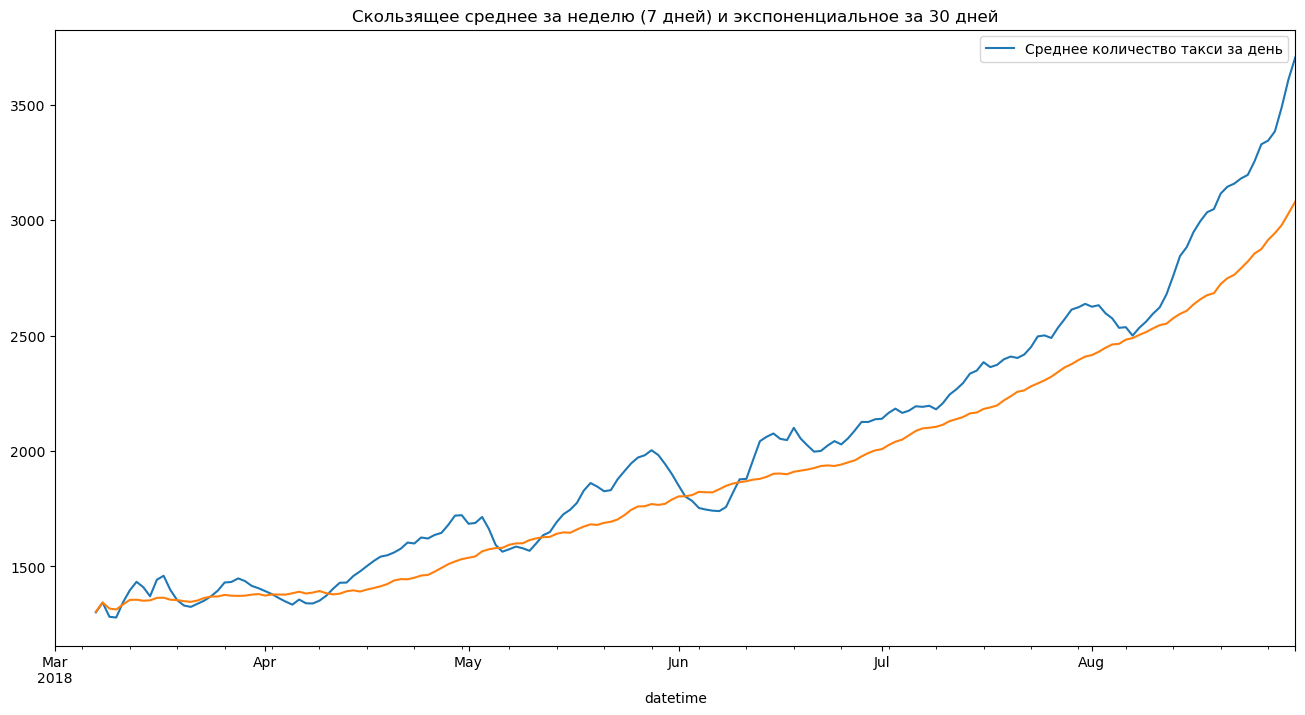

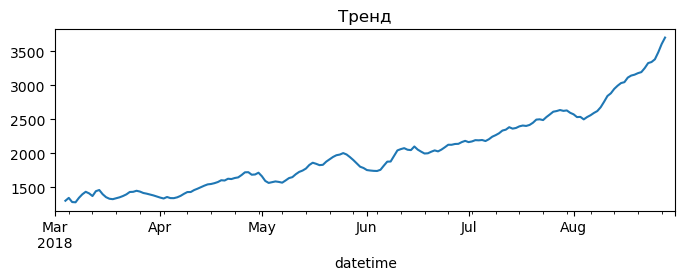

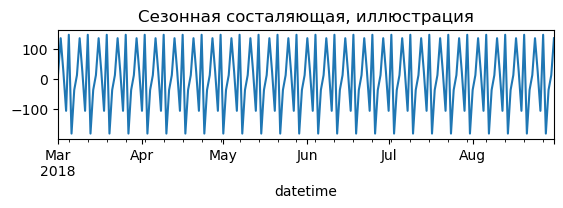

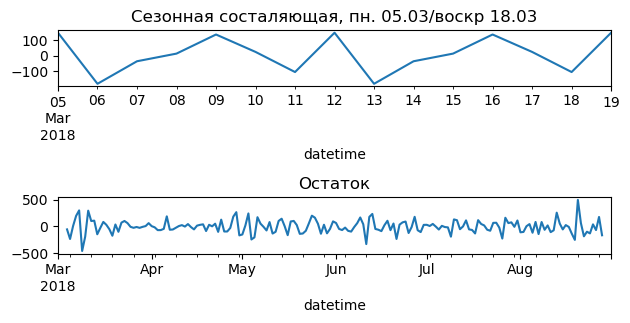

In [104]:
df_d = df.resample('1D').sum()
df_d['num_orders'].rolling(7).mean().plot(figsize=(16, 8))
#df_d['num_orders'].rolling(30).mean().plot(figsize=(16, 8))
#df['num_orders'].rolling(720).mean().plot(figsize=(16, 8))
df_d['num_orders'].rolling(window=30, min_periods=7, win_type='exponential').mean(tau=30).plot(figsize=(16, 8))
plt.legend(['Среднее количество такси за день'])
plt.title('Скользящее среднее за неделю (7 дней) и экспоненциальное за 30 дней')

decomposed = seasonal_decompose(df_d)
 
plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
print('/n')
plt.show()

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная состаляющая, иллюстрация')
plt.show()


plt.subplot(312)
decomposed.seasonal['2018-03-05':'2018-03-19'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая, пн. 05.03/воскр 18.03')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()


## 1.5. Проверка на стационарность <a class="anchor" id="1.5.Стационарность"></a>

1. Проверим, насколько все это правомочно, для часовых и дневных графиков.
2. Для часовиков, ряд стационарен только для уровня значимости 5%, для уровня значимости 1%, ряд нестационарен
3. Для дневных графиков, ряд нестационарен даже для уровня значимости 10%, т.е. рассмотрение дневных графиков формально некоректно

In [105]:
test = adfuller(df['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')


adf:  -3.0689242890279327
p-value:  0.028940051402614794
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


In [106]:
test = adfuller(df_d['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['10%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')


adf:  3.7287913115649953
p-value:  1.0
Critical values:  {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
есть единичные корни, ряд не стационарен


## 1.6. Подготовка признаков <a class="anchor" id="1.6.Подг_признаков"></a>

1. Создадим дополнительные признаки из стационарного ряда
2. часы 
3. дни недели
4. месяц
5. лаги от 1 до 24 часов
6. скользящую средниюю 12 часов сдвинутую на один час назад


In [107]:
def make_features(df, max_lag, rolling_mean_size):
    df['hours'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df.iloc[:,0].shift(lag)

    df['rolling_mean'] = df.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    return df


In [108]:
df = make_features(df, 24, 12)
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hours         4392 non-null   int64  
 2   dayofweek     4392 non-null   int64  
 3   lag_1         4392 non-null   float64
 4   lag_2         4392 non-null   float64
 5   lag_3         4392 non-null   float64
 6   lag_4         4392 non-null   float64
 7   lag_5         4392 non-null   float64
 8   lag_6         4392 non-null   float64
 9   lag_7         4392 non-null   float64
 10  lag_8         4392 non-null   float64
 11  lag_9         4392 non-null   float64
 12  lag_10        4392 non-null   float64
 13  lag_11        4392 non-null   float64
 14  lag_12        4392 non-null   float64
 15  lag_13        4392 non-null   float64
 16  lag_14        4392 non-null   float64
 17  lag_15        4392 non-null

1. Найдем корреляциию

,num_orders,hours,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
num_orders,1.000000,4.184469e-03,-1.967969e-02,0.623635,0.464652,0.320341,0.247929,0.230075,0.237952,0.290977,0.309479,0.269948,0.263071,0.317072,0.332320,0.313664,0.259532,0.237354,0.274209,0.257994,0.212323,0.198838,0.219859,0.267209,0.406704,0.557188,0.691576,0.507899
hours,0.004184,1.000000e+00,9.016515e-18,-0.076343,-0.120093,-0.154237,-0.145387,-0.122258,-0.072605,-0.098803,-0.194732,-0.206301,-0.176513,-0.133748,-0.079828,-0.073305,-0.101425,-0.115624,-0.079130,0.098152,0.288538,0.422403,0.415302,0.356892,0.264005,0.198878,0.004107,-0.205391
dayofweek,-0.019680,9.016515e-18,1.000000e+00,-0.027398,-0.029637,-0.029124,-0.028762,-0.028816,-0.026970,-0.026969,-0.029012,-0.032102,-0.036722,-0.035812,-0.039358,-0.026777,-0.014340,-0.007924,-0.005012,-0.002613,-0.000618,-0.001593,0.000121,0.000522,0.011791,0.021076,0.030720,-0.048163
lag_1,0.623635,-7.634273e-02,-2.739777e-02,1.000000,0.622802,0.464194,0.319795,0.247556,0.228818,0.236671,0.289976,0.309356,0.269620,0.262380,0.316772,0.331543,0.312711,0.258366,0.236451,0.275097,0.259039,0.212732,0.196972,0.219879,0.265786,0.405796,0.555999,0.593945
lag_2,0.464652,-1.200933e-01,-2.963693e-02,0.622802,1.000000,0.622407,0.463626,0.319214,0.246069,0.227058,0.235168,0.289733,0.308816,0.268513,0.261663,0.315963,0.330356,0.311370,0.257041,0.237026,0.275875,0.259062,0.210322,0.196882,0.218036,0.264518,0.404142,0.632582
lag_3,0.320341,-1.542371e-01,-2.912407e-02,0.464194,0.622407,1.000000,0.622205,0.463440,0.318570,0.245333,0.226404,0.235018,0.289501,0.308397,0.268266,0.261118,0.315395,0.329743,0.310866,0.257534,0.237624,0.276076,0.258145,0.210295,0.195970,0.217318,0.263419,0.658376
lag_4,0.247929,-1.453869e-01,-2.876173e-02,0.319795,0.463626,0.622205,1.000000,0.622095,0.463010,0.318001,0.244769,0.226267,0.234802,0.289133,0.308204,0.267751,0.260558,0.314826,0.329318,0.311367,0.258134,0.237855,0.275308,0.258136,0.209482,0.195282,0.216184,0.664562
lag_5,0.230075,-1.222580e-01,-2.881556e-02,0.247556,0.319214,0.463440,0.622095,1.000000,0.621994,0.462865,0.317746,0.244691,0.226173,0.234627,0.289087,0.307806,0.267402,0.260154,0.314624,0.329808,0.311946,0.258446,0.237414,0.275317,0.257668,0.208992,0.194383,0.656357
lag_6,0.237952,-7.260523e-02,-2.697046e-02,0.228818,0.246069,0.318570,0.463010,0.621994,1.000000,0.621294,0.462034,0.317610,0.244283,0.225349,0.234173,0.288277,0.306801,0.266207,0.259183,0.315449,0.330809,0.312287,0.256632,0.237428,0.273865,0.256529,0.206857,0.647590
lag_7,0.290977,-9.880316e-02,-2.696950e-02,0.236671,0.227058,0.245333,0.318001,0.462865,0.621294,1.000000,0.620739,0.462076,0.317351,0.243571,0.225020,0.233177,0.287204,0.305602,0.265312,0.260259,0.316754,0.331444,0.310559,0.256719,0.235788,0.272637,0.254192,0.647002


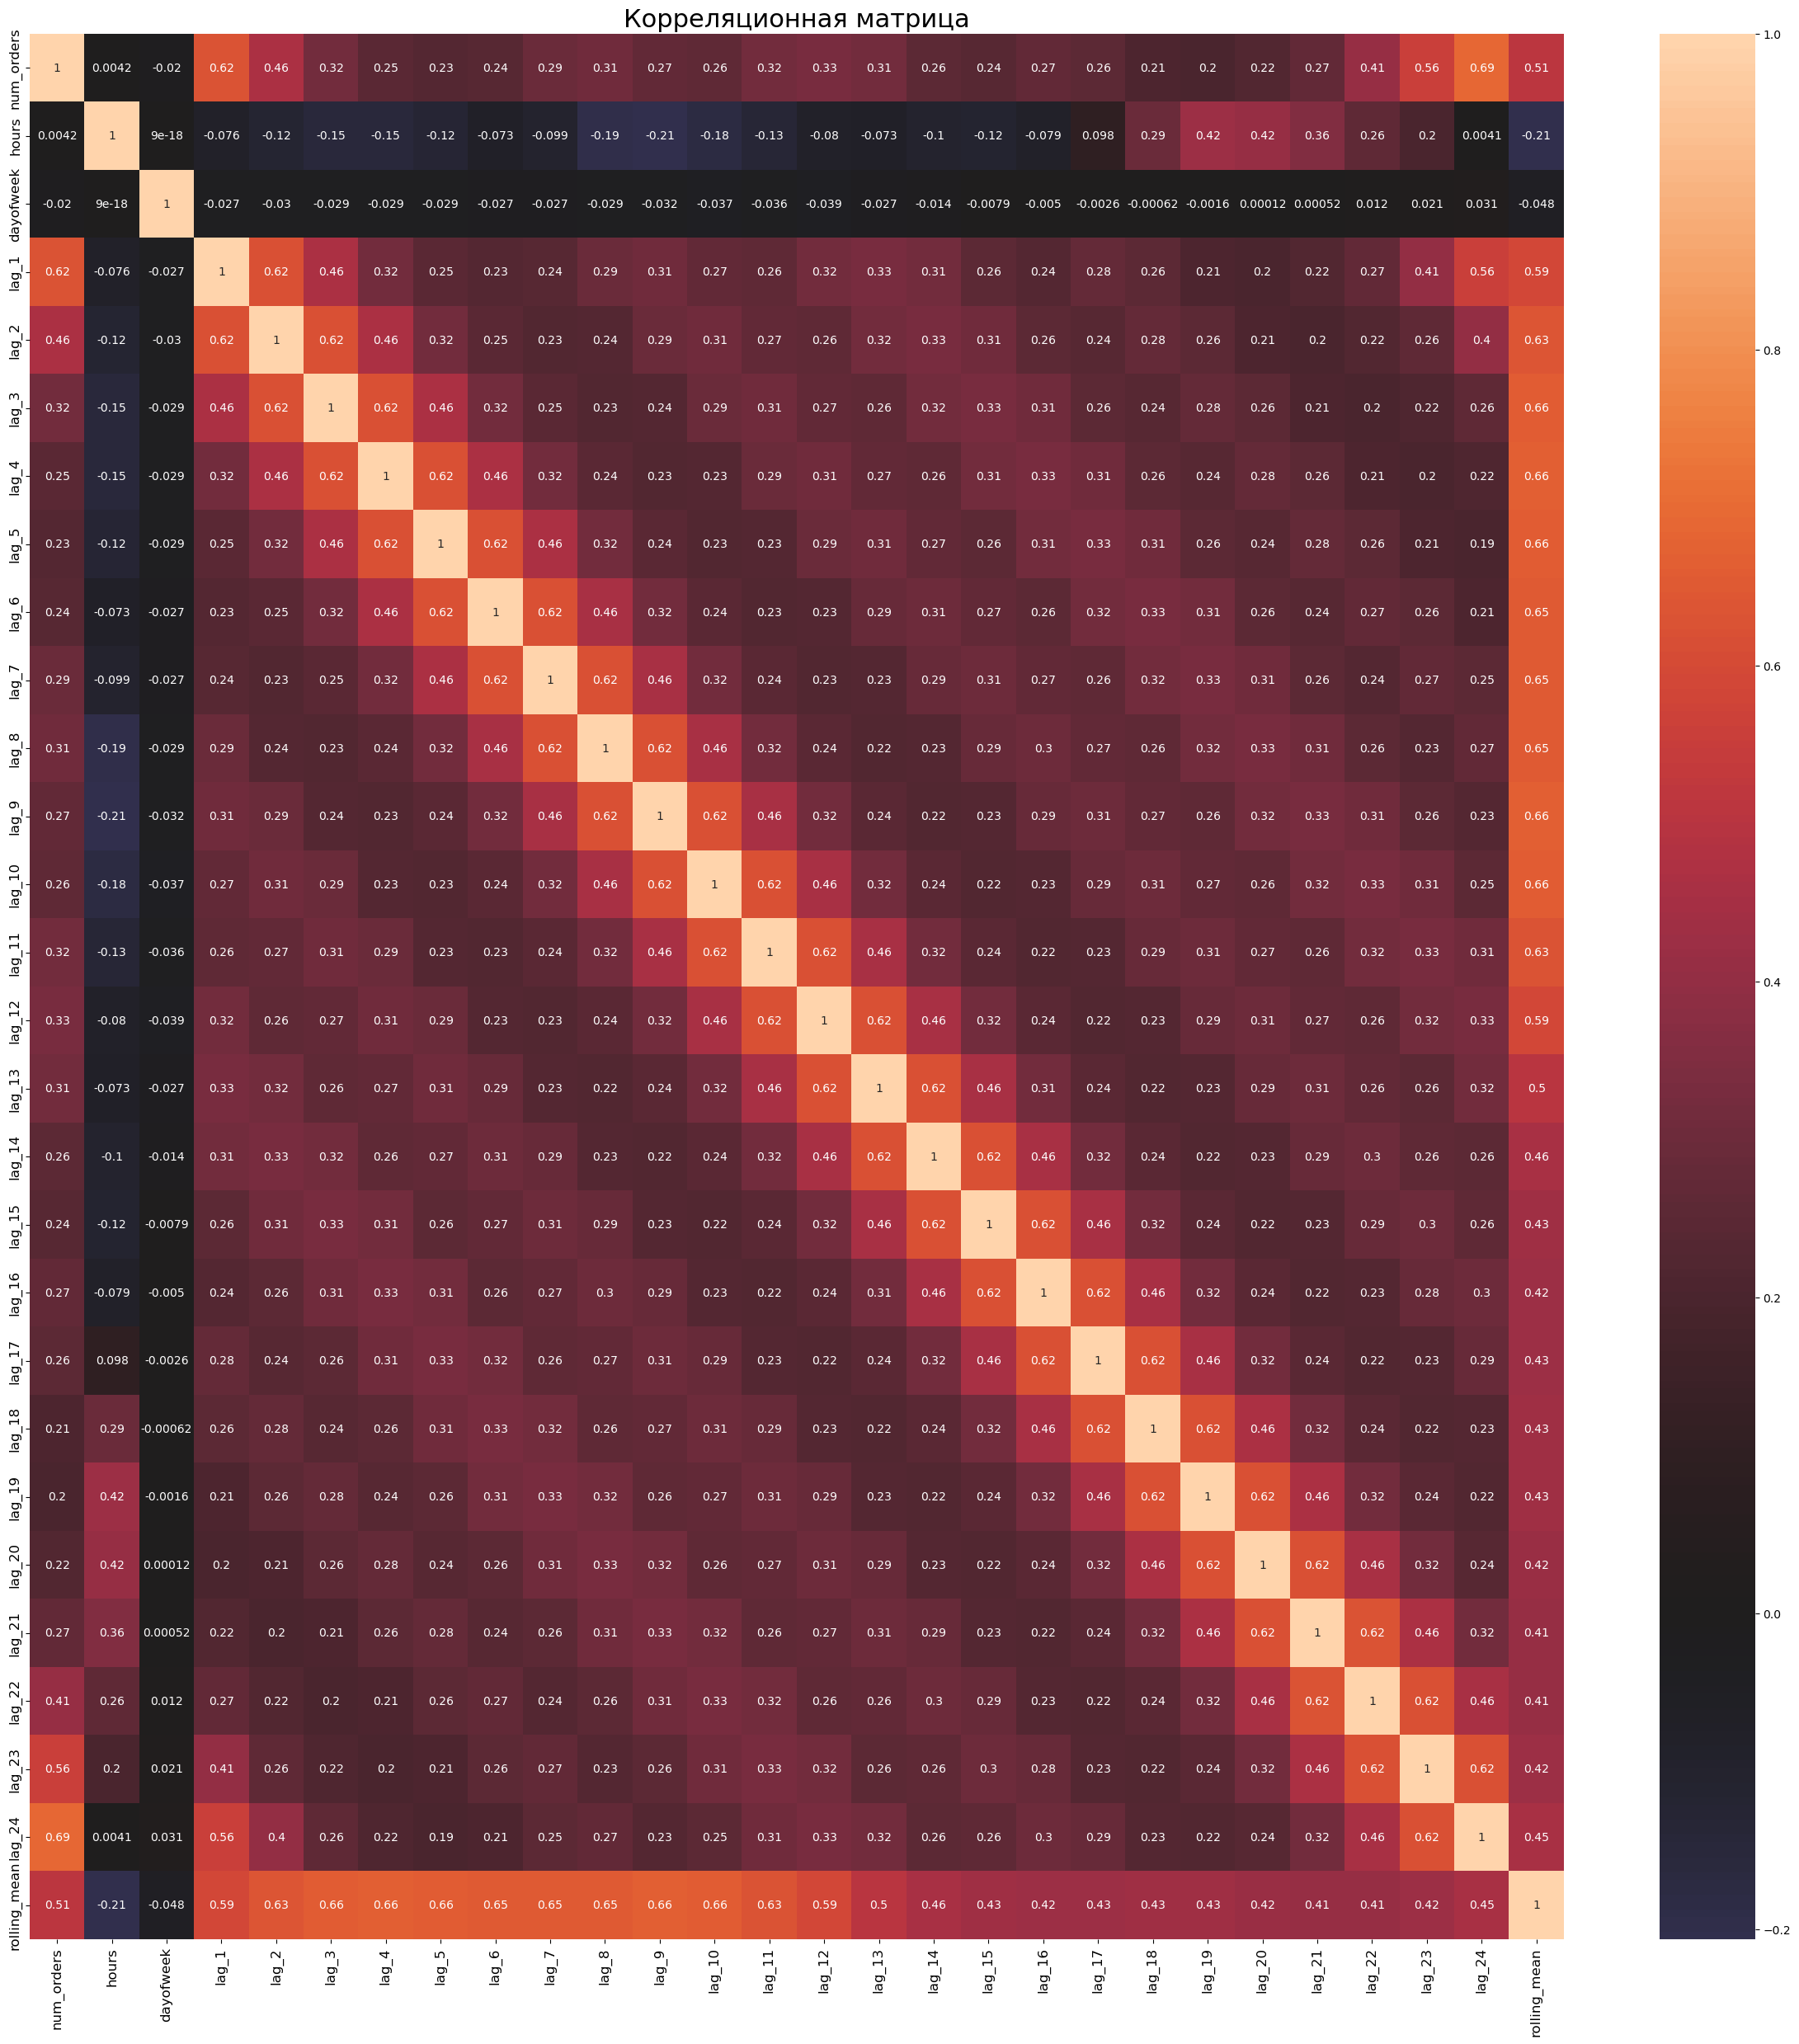

In [109]:
plt.figure(figsize=(30,30))
heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0, annot=True)
#heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
display(df.corr())

plt.title('Корреляционная матрица', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1. Попробовал добавить скользящиее средние. Но они очень сильно коррелируют с лагами и между собой, особенно при лагах менее 10. Мультиколинеарность однако.
2. Поэтому оставил только одну скользящую среднюю, 12.

# 2. Подготовка наборов <a class="anchor" id="2.Подг_наборов"></a>

## 2.1. Разделение наборов на train, test, таргеты и признаки <a class="anchor" id="2.1.Таргет_Призн"></a>

1. Выделим таргет из выборки
2. Разделим  на train, test

In [110]:
print(df.isna().sum())


num_orders      0
hours           0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64


1. Выделил тест, отложил на финальную проверку
2. Проверил, что делит оставшийся сегмен корректно
3. Так как test_size=0.1 по условию задачи, делим оставшийся кусок на 9 частей, что-бы длина valid была примерно равна длине test_size

In [111]:
train,test = train_test_split(df, test_size=0.1, shuffle=False)
#Выделили test
print(train.shape)
print(test.shape)
#
tscv = TimeSeriesSplit(n_splits=9)
#Выделили test

tr_index = train.index

for i, (train_index, valid_index) in enumerate(tscv.split(train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index[0]}:{train_index[-1]}")
    print(f"  Valid:  index={valid_index[0]}:{valid_index[-1]}")


(3952, 28)
(440, 28)
Fold 0:
  Train: index=0:396
  Valid:  index=397:791
Fold 1:
  Train: index=0:791
  Valid:  index=792:1186
Fold 2:
  Train: index=0:1186
  Valid:  index=1187:1581
Fold 3:
  Train: index=0:1581
  Valid:  index=1582:1976
Fold 4:
  Train: index=0:1976
  Valid:  index=1977:2371
Fold 5:
  Train: index=0:2371
  Valid:  index=2372:2766
Fold 6:
  Train: index=0:2766
  Valid:  index=2767:3161
Fold 7:
  Train: index=0:3161
  Valid:  index=3162:3556
Fold 8:
  Train: index=0:3556
  Valid:  index=3557:3951


## 2.2. Инициализация  StandartScaler <a class="anchor" id="2.2.OHE"></a>


1. Инициализируем StandartScaler.
2. Так как у нас трейн переменной длины, что-бы не было утечки, fit запускаем заново после каждого формирования наборов train, test.


In [112]:
scaler = StandardScaler()


# 3. Обучение и  тестирование моделей <a class="anchor" id="3.Обучение_мод"></a>

## 3. 3.1. Линейная регрессия <a class="anchor" id="3.1.LR"></a>

In [113]:
#Линейная регрессия

lr_model = LinearRegression()
models_scores = []

In [114]:
%%time
%precision 4

for j, (train_index, valid_index) in enumerate(tscv.split(train)):
    if j>=7:
        start_time = time.time()
        print(f"Fold {j}:")
#    print(f"  Train: index={train_index[0]}:{train_index[-1]}")
#    print(f"  Test:  index={valid_index[0]}:{valid_index[-1]}")
        X_train = train.loc[train.index[train_index],:].drop('num_orders', axis=1)
        y_train = train.loc[train.index[train_index],'num_orders']
#    print('X_train.info()',X_train.info())
#    print('y_train.info()',y_train.info())
    
        X_valid = train.loc[train.index[valid_index],:].drop('num_orders', axis=1)
        y_valid = train.loc[train.index[valid_index],'num_orders']
#    print('X_valid.info()',X_valid.info())
#    print('y_valid.info()',y_valid.info())

        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_valid_scale = scaler.transform(X_valid)

    
        lr_model.fit(X_train_scale, y_train)
        fit_time = time.time() - start_time
    
        start_time = time.time()
        y_valid_pred = pd.Series(lr_model.predict(X_valid_scale))
        pred_time = time.time() - start_time
    
        score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
#    print(f' best_score: {score_}')
#    print('fit_time = ', fit_time)
#    print('pred_time = ', pred_time)
        models_scores.append(['LinearRegression',j,score_, fit_time, pred_time])
#    #models_scores.append(['LinearRegression',score_, fit_time])
display(models_scores)

Fold 7:
Fold 8:


[['LinearRegression', 7, 32.01579711399697, 0.0250, 0.0000],
 ['LinearRegression', 8, 34.041801642027224, 0.0270, 0.0000]]

Wall time: 57 ms


## 3.2.CatBoost регрессор <a class="anchor" id="3.2.CBR"></a>

1. Теперь, cast boost
2. Долго сходится, не понял, почему, раньше было норм.
3. best_score: 31.994928218615048, best_iter: 7, best_learn_rate: 0.27

In [2]:
%%time

for j, (train_index, valid_index) in enumerate(tscv.split(train)):
    if j>= 7:
        
##################################    start_time = time.time()
        print(f"Fold {j}:")
        X_train = train.loc[train.index[train_index],:].drop('num_orders', axis=1)
        y_train = train.loc[train.index[train_index],'num_orders']
    
        X_valid = train.loc[train.index[valid_index],:].drop('num_orders', axis=1)
        y_valid = train.loc[train.index[valid_index],'num_orders']

        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_valid_scale = scaler.transform(X_valid)
    
        learn_rate_min = 0.15
        learn_rate_max = 0.25

        depth_min = 3
        depth_max = 20

        best_model = None
        best_score = 10000000
        best_iter = 0
        best_learn_rate = 0
        best_depth = 0

        for i in range(1,8):
            print(f'Итерация - {i}')
            learn_rate_ = learn_rate_min + 0.04*i

            params = {'n_estimators': 100,
                      'loss_function':'RMSE',
                      'learning_rate': learn_rate_,
                      'depth': 12,
                      'random_state': RANDOM_STATE,
                      'verbose': 2}
            model = CatBoostRegressor(**params).fit(X_train_scale,y_train)
            y_valid_pred = model.predict(X_valid_scale)
            score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
            if score_ < best_score:
                best_cat_model = model
                best_score = score_
                best_iter = i
                best_learn_rate = learn_rate_
#                best_depth = 0

        print(f' best_score: {best_score}, best_iter: {i}, best_learn_rate: {best_learn_rate}')
    
        start_time = time.time()
        params = {'n_estimators': 100,
                  'loss_function':'RMSE',
                  'learning_rate': best_learn_rate,
                  'depth': 12,
                  'random_state': RANDOM_STATE,
                  'verbose': 2}
        best_cat_model = CatBoostRegressor(**params).fit(X_train_scale,y_train)
        fit_time = time.time() - start_time

        start_time = time.time()
        y_valid_pred = best_cat_model.predict(X_valid_scale)
        pred_time = time.time() - start_time
      
        score_ = mean_squared_error(y_valid, y_valid_pred)**0.5

        models_scores.append(['CatBoost',j,score_, fit_time, pred_time])

display(models_scores)

[['LinearRegression', 7, 32.01579711399697, 0.025, 0.0],
 ['LinearRegression', 8, 34.041801642027224, 0.027, 0.0],
 ['CatBoost', 7, 30.253225280975244, 39.3252, 0.002],
 ['CatBoost', 8, 31.994928218615048, 41.883, 0.002]]

Wall time: 24.8 ms


## 3.3. LightGBM <a class="anchor" id="3.3.LGBM"></a>

 1. Похоже уделал LGBM всех
 2. best_lgbm_model: LGBMRegressor(force_row_wise=True, max_depth=6, metric='rmse',
              min_data_in_leaf=32, objective='regression', verbose=2)
 3. best_iter: 124, best_fold: 8, best_score: 30.62823018811787
 4. best_nleaves: 31, best_max_depth: 10,best_min_data_in_leaf_: 32

In [3]:
%%time

for j, (train_index, valid_index) in enumerate(tscv.split(train)):
    if j>=7:
##################################    start_time = time.time()
        print(f"Fold {j}:")
        X_train = train.loc[train.index[train_index],:].drop('num_orders', axis=1)
        y_train = train.loc[train.index[train_index],'num_orders']
    
        X_valid = train.loc[train.index[valid_index],:].drop('num_orders', axis=1)
        y_valid = train.loc[train.index[valid_index],'num_orders']

        scaler.fit(X_train)
        X_train_scale = scaler.transform(X_train)
        X_valid_scale = scaler.transform(X_valid)  
    
        min_max_depth = 4
        max_max_depth = 8
        best_max_depth = 10
        best_min_data_in_leaf = 2^2
        best_score = 1e12
        best_nleaves = 2^2
    
        for i in range(1,256):
            max_depth_ = randrange(min_max_depth, max_max_depth)
#        print(f'max_depth_: {max_depth_}')
#        print(2**(max_depth_-2), 2**max_depth_)
            nleaves_ = randrange(2**(max_depth_-2), 2**max_depth_)
#        print(f'nleaves_: {nleaves_}')
            min_data_in_leaf_ = randrange(2**(max_depth_-2), 2**max_depth_)
#        print(f'min_data_in_leaf_: {min_data_in_leaf_}')
            params = {'boosting_type': 'gbdt',
                      'objective': 'regression',
                      'metric': 'rmse',
                      'max_depth': max_depth_,
                      'learning_rate': 0.1,
                      'verbose': 2,
                      'num_leaves': nleaves_,
                      'min_data_in_leaf': min_data_in_leaf_,
                      'force_row_wise': True
                     }
            model = LGBMRegressor(**params)
            model.fit(X_train_scale, y_train)
            y_valid_pred = pd.Series(model.predict(X_valid_scale))
            score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
            if score_ < best_score:
                best_lgbm_model = model
                best_iter = i
                best_fold = j
                best_score = score_
                best_nleaves =  nleaves_
                best_max_depth_ = max_depth_
                best_min_data_in_leaf = min_data_in_leaf_
                print('change opt')

        print(f' best_lgbm_model: {best_lgbm_model}')
        print(f' best_iter: {best_iter}, best_fold: {best_fold}, best_score: {best_score}')
        print(f' best_nleaves: {best_nleaves}, best_max_depth: {best_max_depth},best_min_data_in_leaf_: {best_min_data_in_leaf}')
    
        start_time = time.time()

        params = {'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'max_depth': best_max_depth_,
                  'learning_rate': 0.5,
                  'verbose': 2,
                  'num_leaves': best_nleaves,
                  'min_data_in_leaf': best_min_data_in_leaf,
                  'force_row_wise': True} 

        model = LGBMRegressor(**params)
        model.fit(X_train_scale, y_train)
        fit_time = time.time() - start_time         

        start_time = time.time()
        y_valid_pred = best_lgbm_model.predict(X_valid_scale)
        pred_time = time.time() - start_time
      
        score_ = mean_squared_error(y_valid, y_valid_pred)**0.5

        models_scores.append(['LightGBM',j,score_, fit_time, pred_time])

display(models_scores)


[['LinearRegression', 7, 32.01579711399697, 0.025, 0.0],
 ['LinearRegression', 8, 34.041801642027224, 0.027, 0.0],
 ['CatBoost', 7, 30.253225280975244, 39.3252, 0.002],
 ['CatBoost', 8, 31.994928218615048, 41.883, 0.002],
 ['LightGBM', 7, 28.171045943598923, 0.3058, 0.002],
 ['LightGBM', 8, 30.62823018811787, 0.2569, 0.005]]

Wall time: 2 ms


In [117]:

models_scores_df = pd.DataFrame(data = models_scores,columns = ('model','fold','rmse','fit_time','pred_time'))


In [121]:

display(models_scores_df.groupby('model').mean().sort_values('rmse'))


,fold,rmse,fit_time,pred_time
model,,,,
LightGBM,7.5,29.399638,0.281338,0.003503
CatBoost,7.5,31.124077,40.604117,0.001999
LinearRegression,7.5,33.028799,0.025985,0.000000


 1. Финальная проверка test
 2. Модель LightGBM на 0-7 слоте. Слот 8 остался как valid.

In [124]:
%%time

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

X_test_scale = scaler.transform(X_test)
y_test_pred = best_lgbm_model.predict(X_test_scale)
score_ = mean_squared_error(y_test, y_test_pred)**0.5
print(f' Тестовая метрика LightGBM: {score_}')


 Тестовая метрика LightGBM: 46.423358941337455
Wall time: 12 ms


 1. График таргет и прогноз

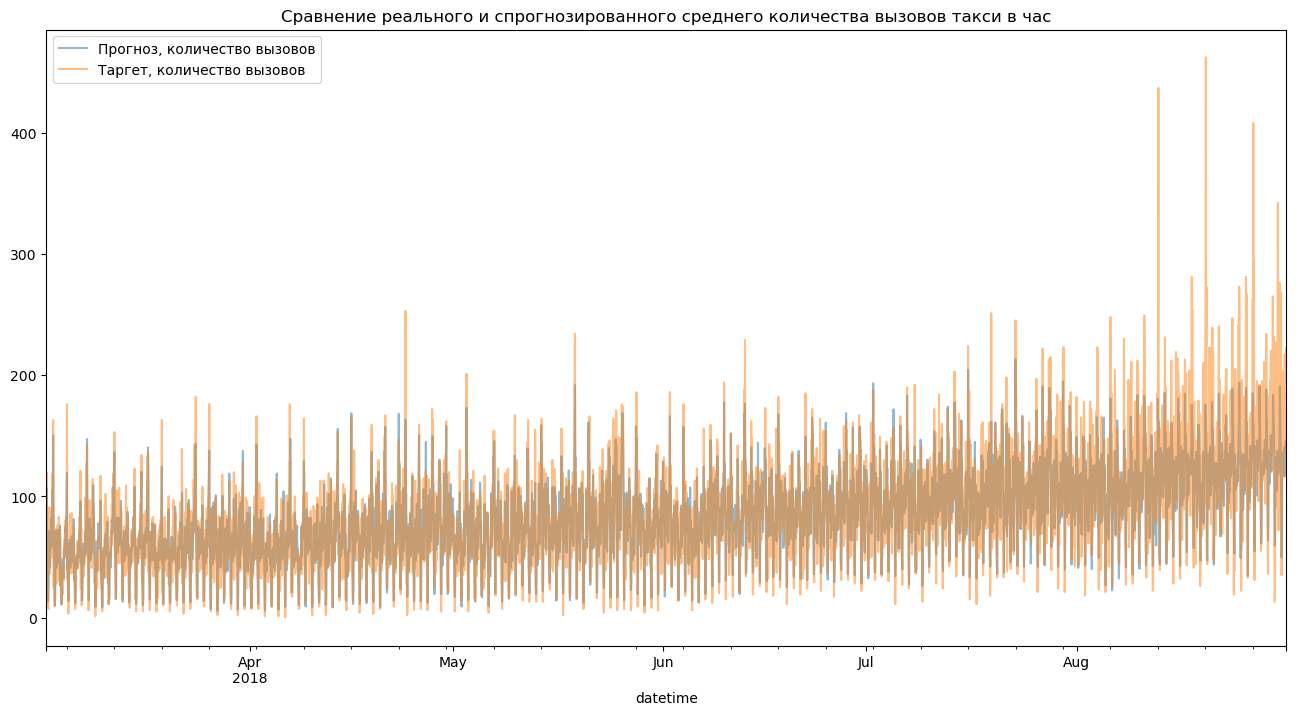

In [129]:
X_all = df.drop('num_orders', axis=1)
X_all_scale = scaler.transform(X_all)
y_pred_all = pd.DataFrame(data=best_lgbm_model.predict(X_all_scale), index = df.index, columns = ['pred'])
y_pred_all['actual'] = df['num_orders']

y_pred_all.plot(figsize=(16, 8), alpha=0.5)
plt.legend(['Прогноз, количество вызовов', 'Таргет, количество вызовов'])
plt.title('Сравнение реального и спрогнозированного среднего количества вызовов такси в час')
plt.show()


# 4. Вывод <a class="anchor" id="4.Вывод"></a>

1. Для решения задачи сделана предобработка данных. Проверена монотонность, стационарность ряда. Сделано несколько иллюстративных графиков.
2. Для дальнейшей работы из временного ряда сгенерированы дополнительные признаки - дни недели, часы дня, лаги, скользящие средние. Данные очищены от NaN.
3. Произведено масштабирование признаков.
4. Произвено разделение на фолды/слоты с помощью tscv.split(train). Так как в начальных фолдах тренд не очень выраженный, очевидно, предсказательная способность и вес предсказаний на начальных фолдах (например train fold=0, valid fold=1) будут искажать прогноз. По этой причине принято решение при прогнозировании брать под valid только дальние промежутки, 7 и 8 фолды.
5. Для оценки алгоритом использовано 3 алгоритма - Линейный, CatBoost, LightGBM.
6. После выбора алгоритма, и фолдов train и valid производится выделение train, valid, target, features и производится оптимизация гиперпараметров. Данные по фолдам для каждого алгоритма усредняются.
7. Минимальная метрика RMSE на тесте - достигнута на алгоритме LightGBM. Алгоритм так-же имеет близкое с Linear regression время fit, predict.
8. Тестирование LightGBM показало соответствие требованиям задачи, RMSE менее 48.
9. Рекомендуется в прод LightGBM...